In [2]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
# cooling and other heating residential profiles


# Load the new Excel file
file_path_cooling = '/mnt/data/new_cooling.xlsx'
cooling_data = pd.ExcelFile(file_path_cooling)

# Load the data from the first sheet
df_cooling = cooling_data.parse(cooling_data.sheet_names[0])

# Generate hourly timestamps for one year (2025)
timestamps = pd.date_range(start='2025-01-01', end='2025-12-31 23:00:00', freq='H')

# Create a DataFrame to hold these timestamps
df_yearly = pd.DataFrame({'timestamp': timestamps})

# Determine day_type based on the day of the week
# 0 = weekday (Monday to Friday), 1 = Saturday, 2 = Sunday
df_yearly['day_of_week'] = df_yearly['timestamp'].dt.dayofweek
df_yearly['day_type'] = df_yearly['day_of_week'].apply(lambda x: 0 if x < 5 else (1 if x == 5 else 2))

# Assign hour (1-24)
df_yearly['hour'] = df_yearly['timestamp'].dt.hour + 1

# Create a smooth bell-shaped temperature profile for 365 days
days_in_year = 365
day_of_year = np.arange(days_in_year)

# Generate a sine wave temperature curve (peak in mid-summer)
temperature_curve = np.sin((2 * np.pi / days_in_year) * (day_of_year - days_in_year / 4))

# Scale to the desired temperature range (19°C to 40°C)
min_temp = 19
max_temp = 40
scaled_temperatures = (temperature_curve + 1) / 2 * (max_temp - min_temp) + min_temp

# Assign these temperatures to each hour of the year
df_yearly['temperature'] = np.repeat(scaled_temperatures, 24)

# Plot the corrected temperature profile
plt.figure(figsize=(15, 5))
plt.plot(df_yearly['timestamp'], df_yearly['temperature'])
plt.title('Corrected Yearly Temperature Profile (Bell Curve)')
plt.xlabel('Date')
plt.ylabel('Temperature (°C)')
plt.grid(True)
plt.tight_layout()
plt.show()

# Round temperature for merging with cooling profile (assumes cooling profiles have integer temperatures)
df_yearly['temperature_rounded'] = df_yearly['temperature'].round().astype(int)

# Merge with the original cooling data
df_final_corrected = pd.merge(
    df_yearly,
    df_cooling,
    left_on=['day_type', 'hour', 'temperature_rounded'],
    right_on=['day_type', 'hour', 'temperature'],
    how='left'
)

# Drop the extra columns for clarity
df_final_corrected.drop(columns=['temperature_rounded', 'day_of_week'], inplace=True)

# Save to an Excel file
output_file = '/mnt/data/corrected_yearly_cooling_profile.xlsx'
df_final_corrected.to_excel(output_file, index=False)


In [ ]:
# Residential space and water, its different than cooling because it contains seasons instead of temperature column

# Load the new Excel file
file_path_space_water = '/mnt/data/new_space_water.xlsx'
space_water_data = pd.ExcelFile(file_path_space_water)

# Load the data from the first sheet
df_space_water = space_water_data.parse(space_water_data.sheet_names[0])

# Calculate average load per season
average_load_per_season = df_space_water.groupby('season')['load'].mean()
print("Average Load per Season:\n", average_load_per_season)

# Determine mapping based on average load (manual step after viewing the print)
# Highest load → Winter (1), Lowest load → Summer (0), Middle → Transition (2)

# Generate hourly timestamps for one year (2013)
timestamps_2013 = pd.date_range(start='2013-01-01', end='2013-12-31 23:00:00', freq='H')

# Create a DataFrame to hold these timestamps
df_yearly_sw = pd.DataFrame({'timestamp': timestamps_2013})

# Determine month and day_type (weekdays=0, Saturday=1, Sunday=2)
df_yearly_sw['month'] = df_yearly_sw['timestamp'].dt.month
df_yearly_sw['day_of_week'] = df_yearly_sw['timestamp'].dt.dayofweek
df_yearly_sw['day_type'] = df_yearly_sw['day_of_week'].apply(lambda x: 0 if x < 5 else (1 if x == 5 else 2))

# Assign hour (1-24)
df_yearly_sw['hour'] = df_yearly_sw['timestamp'].dt.hour + 1

# Map months to seasons based on the derived mapping:
# Season 1 (Winter): Dec, Jan, Feb
# Season 2 (Transition): Mar-May, Sep-Nov
# Season 0 (Summer): Jun-Aug

def get_season(month):
    if month in [12, 1, 2]:
        return 1  # Winter
    elif month in [3, 4, 5, 9, 10, 11]:
        return 2  # Transition
    else:
        return 0  # Summer

df_yearly_sw['season'] = df_yearly_sw['month'].apply(get_season)

# Merge with the original space water heating profile based on day_type, hour, and season
df_final_sw = pd.merge(
    df_yearly_sw,
    df_space_water,
    on=['season', 'day_type', 'hour'],
    how='left'
)

# Drop unnecessary columns for clarity
df_final_sw.drop(columns=['day_of_week', 'month'], inplace=True)

# Save to an Excel file
output_file_sw_2013 = '/mnt/data/yearly_space_water_heating_profile_2013.xlsx'
df_final_sw.to_excel(output_file_sw_2013, index=False)

print(f"File saved to: {output_file_sw_2013}")


In [19]:
file_path_combined = "C:/Users/86435/project_h2/data/heat_demand/industry/load_profiles_sector_wise/combined_load_profiles.xlsx"  # Change path if needed
df_combined = pd.read_excel(file_path_combined, parse_dates=['timestamp'])
df_combined['timestamp'] = df_combined['timestamp'].apply(lambda x: x.replace(year=2019))

In [21]:
df_combined.to_csv('C:/Users/86435/project_h2/data/heat_demand/industry/load_profiles_sector_wise/combined_load_profiles.csv')

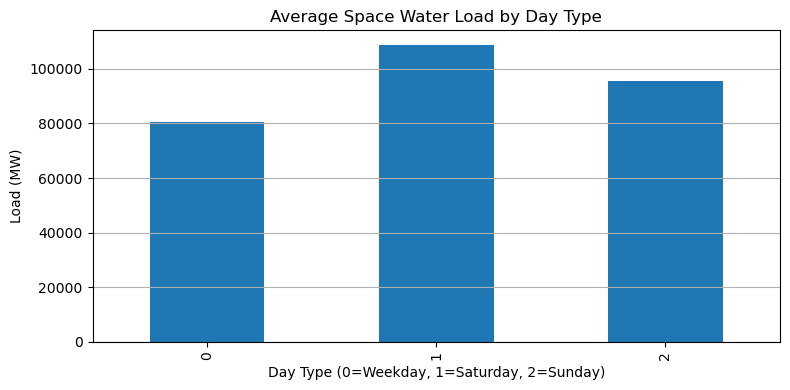

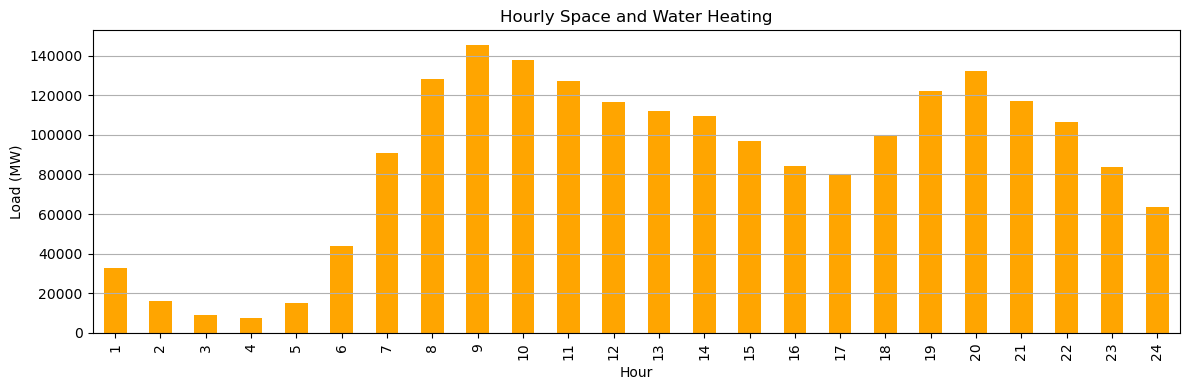

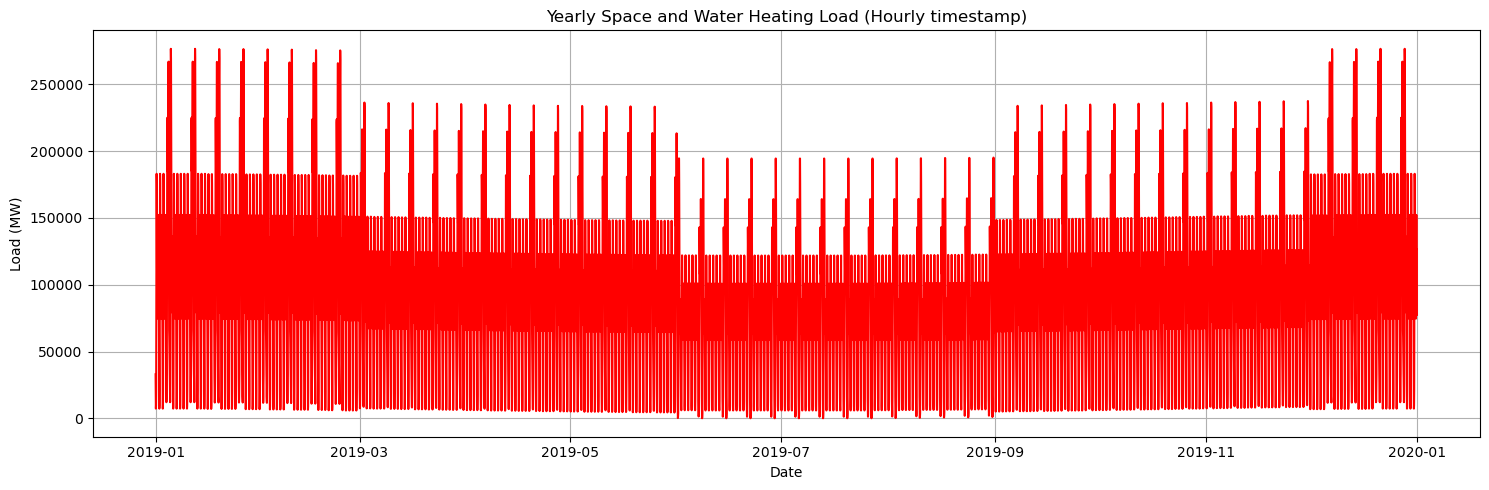

In [16]:
# residential profiles for cooling other heating and space water are done inthe upper two blocks, here is some visualization


# Load the combined load profiles data
file_path_combined = "C:/Users/86435/project_h2/data/heat_demand/residential/heat_demand_data.csv"  # Change path if needed
df_combined = pd.read_csv(file_path_combined, parse_dates=['timestamp'])
df_combined['timestamp'] = df_combined['timestamp'].apply(lambda x: x.replace(year=2019))

# Plot average load_space_water by day_type
plt.figure(figsize=(8, 4))
df_combined.groupby('day_type')['heat_demand MWh'].mean().plot(kind='bar')
plt.title('Average Space Water Load by Day Type')
plt.xlabel('Day Type (0=Weekday, 1=Saturday, 2=Sunday)')
plt.ylabel('Load (MW)')
plt.grid(axis='y')
plt.tight_layout()
# plt.show()

# Plot average load_space_water by hour
plt.figure(figsize=(12, 4))
df_combined.groupby('hour')['heat_demand MWh'].mean().plot(kind='bar', color='orange')
plt.title('Hourly Space and Water Heating')
plt.xlabel('Hour')
plt.ylabel('Load (MW)')
plt.grid(axis='y')
plt.tight_layout()
plt.show()

# # Plot average load_space_water by season
# plt.figure(figsize=(8, 4))
# df_combined.groupby('season')['load_space_water'].mean().plot(kind='bar')
# plt.title('Average Space Water Load by Season')
# plt.xlabel('Season (0=Summer, 1=Winter, 2=Transition)')
# plt.ylabel('Load (MW)')
# plt.grid(axis='y')
# plt.tight_layout()
# # plt.show()

# # Plot daily average load_space_water over the year
# df_combined.set_index('timestamp', inplace=True)
# daily_avg = df_combined['load_space_water'].resample('D').mean()

# plt.figure(figsize=(15, 5))
# daily_avg.plot()
# plt.title('Daily Average Space Water Load - 2013')
# plt.xlabel('Date')
# plt.ylabel('Load (MW)')
# plt.grid(True)
# plt.tight_layout()
# # plt.show()


# Plot hourly load_space_water for the whole year
plt.figure(figsize=(15, 5))
plt.plot(df_combined['timestamp'], df_combined['heat_demand MWh'], color='red')
plt.title('Yearly Space and Water Heating Load (Hourly timestamp)')
plt.xlabel('Date')
plt.ylabel('Load (MW)')
plt.grid(True)
plt.tight_layout()
plt.show()

